# Modeling oriented EDA

- 모델을 완성하기전에 EDA가 포함되어있음, 짧지만 시작을 위한 정보는 다 포함되어있다. 
**About** : This notebooks contains the EDA I had to do before starting to build models.
It is quite short but contains all the information I needed to get started.

No pointless plots, only stuff you'll need for modeling :)

In [1]:
import os
import json
import matplotlib
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

matplotlib.rcParams['figure.figsize'] = (12, 8)

In [2]:
DATA_PATH = "/kaggle/input/learning-equality-curriculum-recommendations/"

In [3]:
topics = pd.read_csv(DATA_PATH + "topics.csv")
content = pd.read_csv(DATA_PATH + "content.csv")
correlations = pd.read_csv(DATA_PATH + "correlations.csv")

## Topics

In [4]:
topics

,id,title,description,channel,category,level,language,parent,has_content
0,t_00004da3a1b2,Откриването на резисторите,"Изследване на материали, които предизвикват на...",000cf7,source,4,bg,t_16e29365b50d,True
1,t_000095e03056,Unit 3.3 Enlargements and Similarities,NaN,b3f329,aligned,2,en,t_aa32fb6252dc,False
2,t_00068291e9a4,Entradas e saídas de uma função,Entenda um pouco mais sobre funções.,8e286a,source,4,pt,t_d14b6c2a2b70,True
3,t_00069b63a70a,Transcripts,NaN,6e3ba4,source,3,en,t_4054df11a74e,True
4,t_0006d41a73a8,Графики на експоненциални функции (Алгебра 2 н...,Научи повече за графиките на сложните показате...,000cf7,source,4,bg,t_e2452e21d252,True
...,...,...,...,...,...,...,...,...,...
76967,t_fffb0bf2801d,4.3 Graph of functions,NaN,e77b55,aligned,4,en,t_676e6a1a4dc7,False
76968,t_fffbe1d5d43c,Inscribed shapes problem solving,Use properties of inscribed angles to prove pr...,0c929f,source,4,sw,t_50145b9bab3f,True
76969,t_fffe14f1be1e,Lección 7,NaN,6e90a7,aligned,6,es,t_d448c707984d,True
76970,t_fffe811a6da9,تحديد العلاقة بين الإحداثيّات القطبية والإحداث...,5b9e5ca86571f90499ea987f,9fd860,source,2,ar,t_5b4f3ba4eb7d,True


- 80k training topics

### Title &  Description

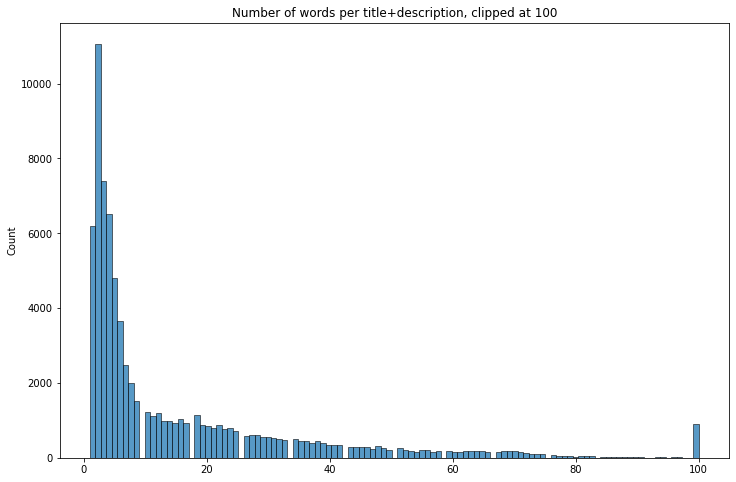

In [5]:
# texts데이터 생성
texts = topics['title'].fillna('') + ' ' + topics['description'].fillna('')

# 텍스트 띄워쓰기 기준으로 길이를 체크했을때 0보다 작으면 0, 100보다 크면 100으로 할당 
title_desc_len = np.clip(texts.apply(lambda x: len(x.strip().split(' '))), 0, 100)

sns.histplot(title_desc_len)
plt.title('Number of words per title+description, clipped at 100')
plt.show()

- 결측치를 0으로 대치함으로써 처리
- 100개 단어 이하가 대부분의 텍스트를 차지함으로 트랜스포머 사용

### Source & content

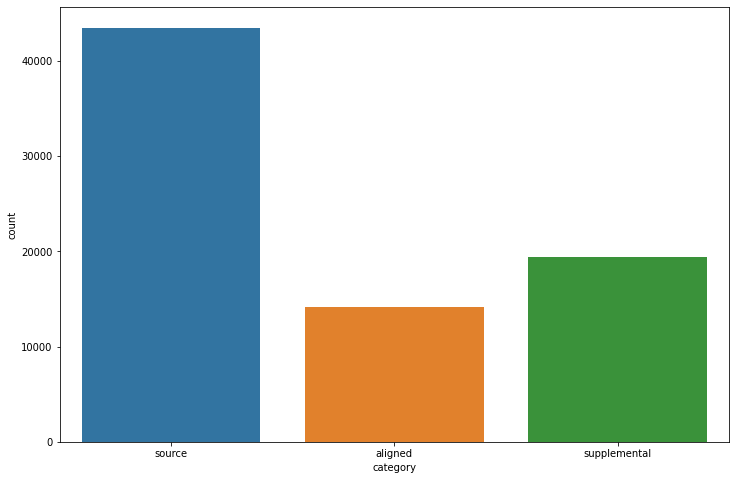

In [6]:
sns.countplot(x='category', data=topics)
plt.show()

- 테스트에는 Source범주가 있는 토픽이 없으므로 이를 무시하고 평가셋을 만들어야함

In [7]:
print(f'Proportion of "useful" topics : {topics["has_content"].mean() :.3f}')

Proportion of "useful" topics : 0.799


- 토픽의 20%가 관련된 콘텐츠를 가지고 있지않다. 그래서 이 컬럼을 추정에 사용하지 않음

### Language

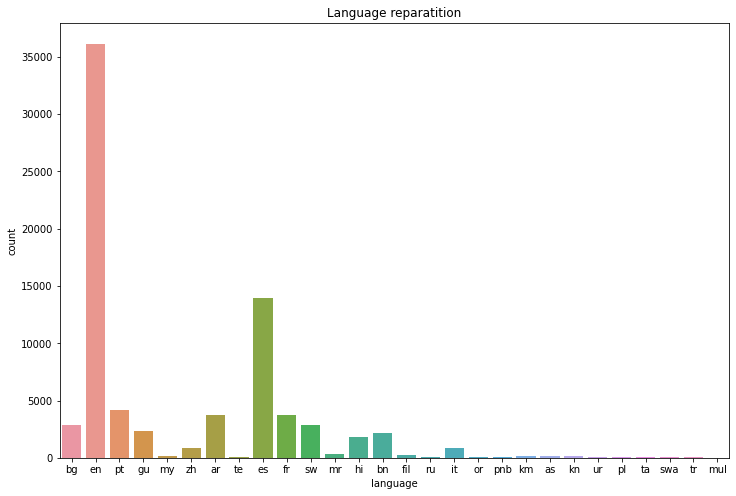

In [8]:
sns.countplot(x="language", data=topics)
plt.title('Language reparatition')
plt.show()

- 다국어지만 영어가 대부분이기 때문에 다국어(XLM-Roberta)와 영어(deberta)모델이 모두 실행가능해야한다.
- 흥미로운 점은 같은 언어를 가진 컨텐츠만 매치할 수 있다는 것이다.

### Channels

Number of channels : 171


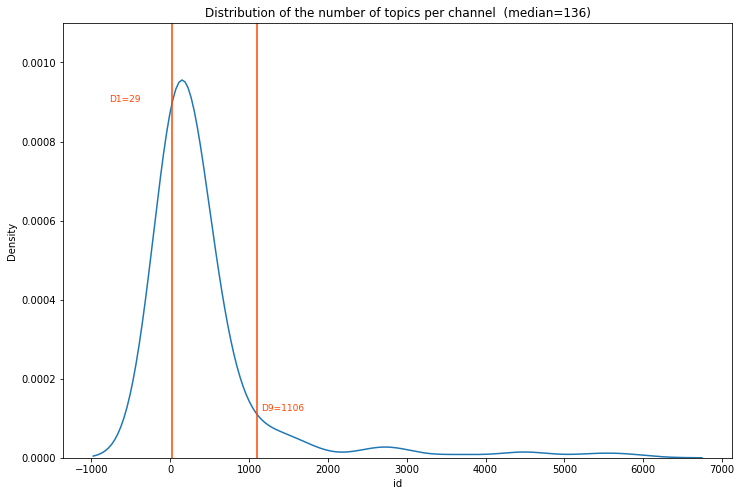

In [9]:
# 채널의 갯수
print("Number of channels :", len(topics['channel'].unique()))

#채널별 id의 갯수
agg = topics.groupby('channel').agg(lambda x: len(list(x)))['id']

# 밀도 그래프, 중앙값 136
sns.kdeplot(agg)
plt.title(f'Distribution of the number of topics per channel  (median={np.median(agg):.0f})')

d1 = int(np.percentile(agg, 10))
plt.axvline(d1, c="orangered")
plt.text(d1 - 800, 0.0009, s=f'D1={d1}', c="orangered", size=9)

d9 = int(np.percentile(agg, 90))
plt.axvline(d9, c="orangered")
plt.text(d9 + 50, 0.00012, s=f'D9={d9}', c="orangered", size=9)

plt.ylim(0, 0.0011)
plt.show()

- 171 channels, with a lot of topics per channel

### Tree example

In [10]:
# 채널 ed5f98에 해당되는 데이터를 뎁스 순으로 나열
tree = topics[topics["channel"] == "ed5f98"].sort_values('level').reset_index(drop=True)  # this one is not too big to be displayed entirely

In [11]:
tree

,id,title,description,channel,category,level,language,parent,has_content
0,t_b7da63fc32b8,PhET Interactive Simulations (English),NaN,ed5f98,source,0,en,NaN,False
1,t_f8440c0567e6,Math,NaN,ed5f98,source,1,en,t_b7da63fc32b8,False
2,t_db1e3c2528f0,Chemistry,NaN,ed5f98,source,1,en,t_b7da63fc32b8,True
3,t_c6a02176fed4,Biology,NaN,ed5f98,source,1,en,t_b7da63fc32b8,True
4,t_48d63851f100,Physics,NaN,ed5f98,source,1,en,t_b7da63fc32b8,False
5,t_670b544223ff,By Level,NaN,ed5f98,source,1,en,t_b7da63fc32b8,False
6,t_abee56fbd20f,Earth Science,NaN,ed5f98,source,1,en,t_b7da63fc32b8,True
7,t_d2ed1315182a,Sound and Waves,NaN,ed5f98,source,2,en,t_48d63851f100,True
8,t_afa3f6a838bf,Light and Radiation,NaN,ed5f98,source,2,en,t_48d63851f100,True
9,t_9ef587394758,Electricity Magnets and Circuits,NaN,ed5f98,source,2,en,t_48d63851f100,True


In [12]:
import os
import pydot
import pandas as pd
from IPython.display import Image


# 트리를 그려본다.
def plot_tree(tree):
    """
    Adapted from
    https://www.kaggle.com/code/pjmathematician/lecr-topic-tree-visualization
    """
    graph = pydot.Dot(graph_type='graph')
    
    for _, row in tree.iterrows():
        # Get the node data
        node_id = row['id']
        parent_id = row['parent']
        title = row['title']
        level = row['level']

        # Create a node for the current row
        # 이름을 id로하고 라벨을 제목으로한 노드 생성
        node = pydot.Node(name=str(node_id), label=title, shape='box')
        # 부모 노드 parent id
        parent_node = graph.get_node(parent_id)
        
        # 뎁스가 3이상이면 계속함
        if level > 3:
            continue
        # 뎁스가 0이면 노드 추가
        if level == 0:
            graph.add_node(node)
        # 뎁스가 0이 아니면 parent_id 와 매칭되는지 파악하고 노드 추가
        elif graph.get_node(parent_id):
            graph.add_node(node)

        # Connect the node to its parent, if it has one
        # 레벨이 0이 아니고 parent_id를 가지고 있으면 노드와 부모 노드에서 생성
        if level != 0 and graph.get_node(parent_id):
            # Create an edge between the node and its parent
            edge = pydot.Edge(src=str(parent_id), dst=str(node_id))
            graph.add_edge(edge)

    graph.write_png('tree.png')
    image = Image(filename='tree.png')
    display(image)
    
    os.remove('tree.png')

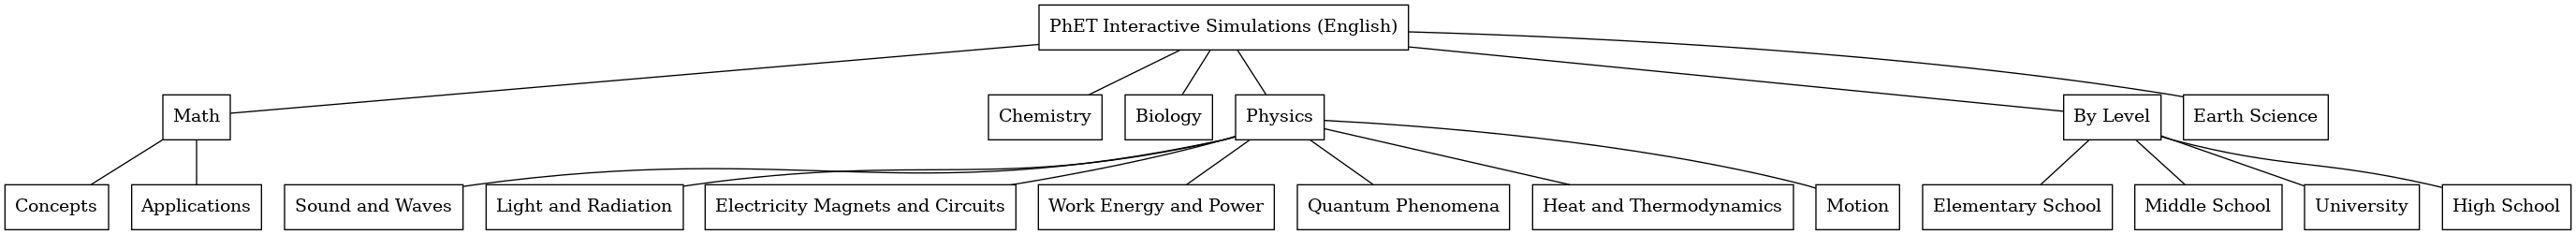

In [13]:
plot_tree(tree)

## Contents

In [14]:
content

,id,title,description,kind,text,language,copyright_holder,license
0,c_00002381196d,"Sumar números de varios dígitos: 48,029+233,930","Suma 48,029+233,930 mediante el algoritmo está...",video,NaN,es,NaN,NaN
1,c_000087304a9e,Trovare i fattori di un numero,Sal trova i fattori di 120.\n\n,video,NaN,it,NaN,NaN
2,c_0000ad142ddb,Sumar curvas de demanda,Cómo añadir curvas de demanda\n\n,video,NaN,es,NaN,NaN
3,c_0000c03adc8d,Nado de aproximação,Neste vídeo você vai aprender o nado de aproxi...,document,\nNado de aproximação\nSaber nadar nas ondas ...,pt,Sikana Education,CC BY-NC-ND
4,c_00016694ea2a,geometry-m3-topic-a-overview.pdf,geometry-m3-topic-a-overview.pdf,document,Estándares Comunes del Estado de Nueva York\n\...,es,Engage NY,CC BY-NC-SA
...,...,...,...,...,...,...,...,...
154042,c_fffcbdd4de8b,2. 12: Diffusion,NaN,html5,What will eventually happen to these dyes?\n\n...,en,CSU and Merlot,CC BY-NC-SA
154043,c_fffe15a2d069,Sommare facendo gruppi da 10,Sal somma 5+68 spezzando il 5 in un 2 e un 3.\n\n,video,NaN,it,NaN,NaN
154044,c_fffed7b0d13a,Introdução à subtração,Sal fala sobre o que significa subtrair. Os ex...,video,NaN,pt,NaN,NaN
154045,c_ffff04ba7ac7,SA of a Cone,NaN,video,NaN,en,NaN,NaN


- 150k rows !

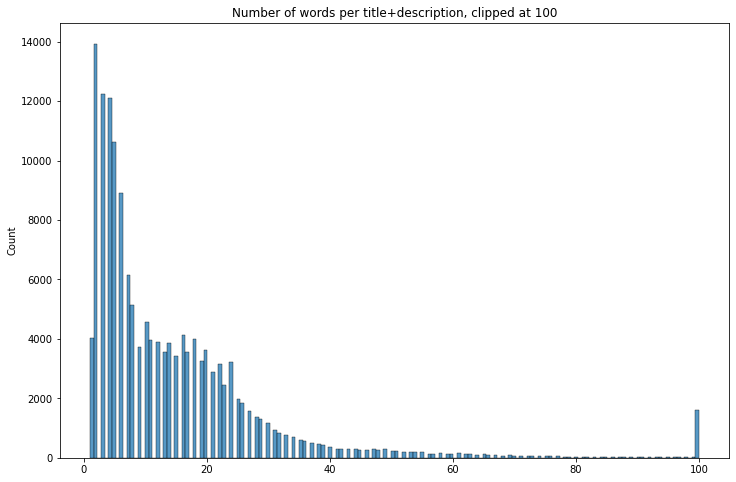

In [15]:
# 텍스트 생성
texts = content['title'].fillna('') + ' ' + content['description'].fillna('')
# 아웃라이어 처리
title_desc_len = np.clip(texts.apply(lambda x: len(x.strip().split(' '))), 0, 100)

sns.histplot(title_desc_len)
plt.title('Number of words per title+description, clipped at 100')
plt.show()

- 요약이 누락되어도 트랜스포머가 처리 가능
- 100개 미만인 단어 뿐만아니라,트랜스포머에 토픽 * 컨텐츠 데이터를 쉽게 처리가능

### Language
- Same as for topics

### Kind & text

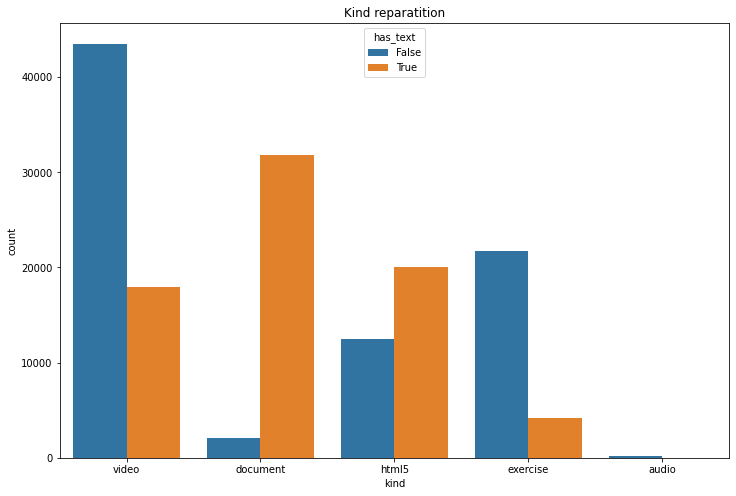

In [16]:
content['has_text'] = ~content['text'].isna()

sns.countplot(x="kind", hue="has_text", data=content)
plt.title('Kind reparatition')
plt.show()

- 어떻게 처리할지 모름

## Correlations
- The target !

In [17]:
correlations

,topic_id,content_ids
0,t_00004da3a1b2,c_1108dd0c7a5d c_376c5a8eb028 c_5bc0e1e2cba0 c...
1,t_00068291e9a4,c_639ea2ef9c95 c_89ce9367be10 c_ac1672cdcd2c c...
2,t_00069b63a70a,c_11a1dc0bfb99
3,t_0006d41a73a8,c_0c6473c3480d c_1c57a1316568 c_5e375cf14c47 c...
4,t_0008768bdee6,c_34e1424229b4 c_7d1a964d66d5 c_aab93ee667f4
...,...,...
61512,t_fff830472691,c_61fb63326e5d c_8f224e321c87
61513,t_fff9e5407d13,c_026db653a269 c_0fb048a6412c c_20de77522603 c...
61514,t_fffbe1d5d43c,c_46f852a49c08 c_6659207b25d5
61515,t_fffe14f1be1e,c_cece166bad6a


In [18]:
# 콘텐츠 아이디를 잘라서 리스트의 길이를 구함
n_corrs = correlations['content_ids'].apply(lambda x: len(x.split(' ')))

print('Total number of correlations :', n_corrs.sum())
print('Average number of correlations per topic :', np.round(n_corrs.mean(), 1))
print('Minimum number of correlations per topic :', n_corrs.min())
print('Maximum number of correlations per topic :', n_corrs.max())

Total number of correlations : 279919
Average number of correlations per topic : 4.6
Minimum number of correlations per topic : 1
Maximum number of correlations per topic : 293


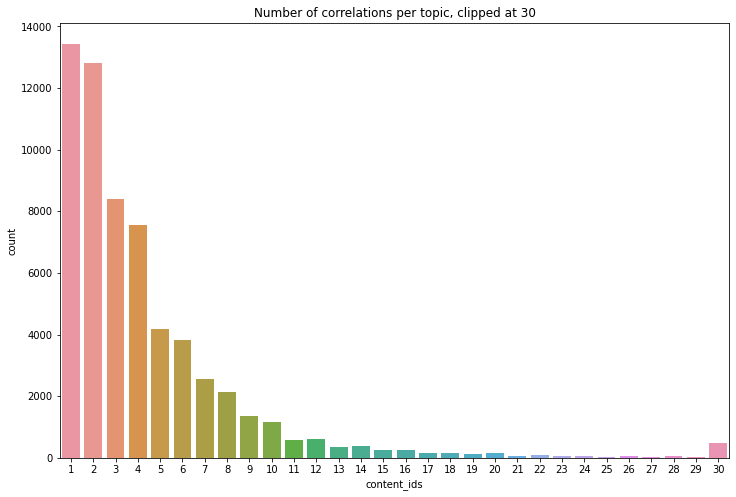

In [19]:
sns.countplot(x=np.clip(n_corrs, 0, 30))
plt.title('Number of correlations per topic, clipped at 30')
plt.show()

## Train/val Split

- 검증하는것은 여기서 쉽지않다. 토픽과 콘텐츠 모두 새로운 데이터가 테스트셋에 있기때문이다. 
- source 데이터를 무시한다(테스트 데이터에 없기때문)
- 채널을 분리한다. 테스트셋에도 새로운 데이터가 존재할것이기때문
- 관련 콘텐츠사이에서 중복을 최소화하는 분할을 찾아야한다. 

In [20]:
# 토픽에서 source데이터가 아닌것들의 채널, id데이터를 가져온다.
topics_val = topics[topics['category'] != "source"][["channel", "id"]]
# 평가 셋 : id를 기준으로  correlation과 합친다.
topics_val = topics_val.merge(correlations, left_on='id', right_on='topic_id')

# 채널 기준으로 토픽 평가셋을 뭉치고 list형태로 반환한다.
channel_val = topics_val.groupby("channel").agg(list).reset_index()
# 위 리스트의 데이터를 순회하면서 공백기준으로 자르고 합친후 유니크한 리스트를 구한다
channel_val['content_ids'] = channel_val['content_ids'].apply(lambda x: list(np.unique(np.concatenate([x_.split(' ') for x_ in x]))))

In [21]:
topics_val

,channel,id,topic_id,content_ids
0,5223e0,t_0008768bdee6,t_0008768bdee6,c_34e1424229b4 c_7d1a964d66d5 c_aab93ee667f4
1,ebc86c,t_0008a1bd84ba,t_0008a1bd84ba,c_7ff92a954a3d c_8790b074383e
2,e77b55,t_000d1fb3f2f5,t_000d1fb3f2f5,c_07f1d0eec4b2 c_15a6fb858696 c_175e9db3fc44 c...
3,a91e32,t_00102869fbcb,t_00102869fbcb,c_005e793bd0c5 c_066737fa5146 c_08b2070f92e0 c...
4,2ee29d,t_0012a45fa09c,t_0012a45fa09c,c_dde078b8ea7a
...,...,...,...,...
24998,998df9,t_fff1f01cfeb0,t_fff1f01cfeb0,c_6cbb967868c2 c_d49c75c4d6f5
24999,2ee29d,t_fff51448598c,t_fff51448598c,c_054e15d2ff3f c_113437812aa0 c_9c817a2bcb3c c...
25000,d5fb04,t_fff7782561f4,t_fff7782561f4,c_bca8280a9ad1
25001,71fd51,t_fff9e5407d13,t_fff9e5407d13,c_026db653a269 c_0fb048a6412c c_20de77522603 c...


In [22]:
channel_val = topics_val.groupby("channel").agg(list).reset_index()
channel_val

,channel,id,topic_id,content_ids
0,00a2b4,"[t_02bcfa7b72ec, t_03ea6cb9a100, t_04df4fee08b...","[t_02bcfa7b72ec, t_03ea6cb9a100, t_04df4fee08b...",[c_17c294443a72 c_a1a8ec93ef87 c_dd739e116435 ...
1,018d08,"[t_02dc6d761be0, t_08e133229173, t_0a854d263d4...","[t_02dc6d761be0, t_08e133229173, t_0a854d263d4...","[c_d08720ccc03c, c_09ff49c0fc41 c_5f84b6a898cb..."
2,01dbc1,"[t_00d34df87981, t_04e9089b262b, t_0514fdcbbb7...","[t_00d34df87981, t_04e9089b262b, t_0514fdcbbb7...",[c_58046dd1c0fb c_67bc1202213e c_9546778f4db5 ...
3,02be07,"[t_010709c0bd20, t_09ddd664d97a, t_0cb2fce563c...","[t_010709c0bd20, t_09ddd664d97a, t_0cb2fce563c...","[c_1fb978405868, c_31ac67a4a32c, c_ef1ef3db32d..."
4,03de11,"[t_022173184544, t_05cc9e5e5ace, t_213c274fb8e...","[t_022173184544, t_05cc9e5e5ace, t_213c274fb8e...",[c_1799a40ef38a c_31630aba3e05 c_463dd609a07c ...
...,...,...,...,...
89,f08256,"[t_0ea9bbb76565, t_1406f1a6b5c1, t_2bc5e5c4074...","[t_0ea9bbb76565, t_1406f1a6b5c1, t_2bc5e5c4074...","[c_12afd8ac44f3 c_f091ff657564, c_04355e021c89..."
90,f65044,"[t_05af761272de, t_0716dfd92e2f, t_0926a1d3175...","[t_05af761272de, t_0716dfd92e2f, t_0926a1d3175...",[c_1b6e55cd1ba5 c_74280466106f c_afe51e041bf0 ...
91,f9db19,"[t_0892bf58bd43, t_0b068faa6ecc, t_13cf6498ec7...","[t_0892bf58bd43, t_0b068faa6ecc, t_13cf6498ec7...","[c_332c37eac81c c_8f9fc13f395e c_b686a7ad414d,..."
92,fc1d48,"[t_07971941376e, t_0845c025e1a7, t_0c658abe07c...","[t_07971941376e, t_0845c025e1a7, t_0c658abe07c...","[c_004a1d069666, c_2785814b6cef c_bc7948bbc891..."


In [23]:
channel_val['content_ids'].apply(lambda x: list(np.unique(np.concatenate([x_.split(' ') for x_ in x]))))

0     [c_02e88da35f4b, c_03cf470094b6, c_03d5ee675af...
1     [c_019851303b20, c_0217c8281348, c_067615a34b1...
2     [c_010a78fb68ce, c_010fdaf4ab89, c_01b0fe81ce8...
3     [c_015e188283ac, c_0978a9c8676d, c_09d6c649128...
4     [c_0085c735763e, c_02161554e6df, c_02436b17b91...
                            ...                        
89    [c_04355e021c89, c_0512284f6eb8, c_0e6fbcb7acf...
90    [c_000a61f0aac7, c_0188a4060bb4, c_0258b0673a2...
91    [c_04a6364b3d80, c_05f32c45ff5f, c_0980ff1bda3...
92    [c_004a1d069666, c_0bbeb346f61d, c_1343e320145...
93    [c_0017be870dc8, c_010ae96ff43f, c_010bdbe59c7...
Name: content_ids, Length: 94, dtype: object

In [24]:
channel_val

,channel,id,topic_id,content_ids
0,00a2b4,"[t_02bcfa7b72ec, t_03ea6cb9a100, t_04df4fee08b...","[t_02bcfa7b72ec, t_03ea6cb9a100, t_04df4fee08b...",[c_17c294443a72 c_a1a8ec93ef87 c_dd739e116435 ...
1,018d08,"[t_02dc6d761be0, t_08e133229173, t_0a854d263d4...","[t_02dc6d761be0, t_08e133229173, t_0a854d263d4...","[c_d08720ccc03c, c_09ff49c0fc41 c_5f84b6a898cb..."
2,01dbc1,"[t_00d34df87981, t_04e9089b262b, t_0514fdcbbb7...","[t_00d34df87981, t_04e9089b262b, t_0514fdcbbb7...",[c_58046dd1c0fb c_67bc1202213e c_9546778f4db5 ...
3,02be07,"[t_010709c0bd20, t_09ddd664d97a, t_0cb2fce563c...","[t_010709c0bd20, t_09ddd664d97a, t_0cb2fce563c...","[c_1fb978405868, c_31ac67a4a32c, c_ef1ef3db32d..."
4,03de11,"[t_022173184544, t_05cc9e5e5ace, t_213c274fb8e...","[t_022173184544, t_05cc9e5e5ace, t_213c274fb8e...",[c_1799a40ef38a c_31630aba3e05 c_463dd609a07c ...
...,...,...,...,...
89,f08256,"[t_0ea9bbb76565, t_1406f1a6b5c1, t_2bc5e5c4074...","[t_0ea9bbb76565, t_1406f1a6b5c1, t_2bc5e5c4074...","[c_12afd8ac44f3 c_f091ff657564, c_04355e021c89..."
90,f65044,"[t_05af761272de, t_0716dfd92e2f, t_0926a1d3175...","[t_05af761272de, t_0716dfd92e2f, t_0926a1d3175...",[c_1b6e55cd1ba5 c_74280466106f c_afe51e041bf0 ...
91,f9db19,"[t_0892bf58bd43, t_0b068faa6ecc, t_13cf6498ec7...","[t_0892bf58bd43, t_0b068faa6ecc, t_13cf6498ec7...","[c_332c37eac81c c_8f9fc13f395e c_b686a7ad414d,..."
92,fc1d48,"[t_07971941376e, t_0845c025e1a7, t_0c658abe07c...","[t_07971941376e, t_0845c025e1a7, t_0c658abe07c...","[c_004a1d069666, c_2785814b6cef c_bc7948bbc891..."


In [25]:
#자카드 영역을 구한다
def iou(a, b):
    return len(set(a).intersection(set(b))) / len(set(a + b))

In [26]:
ious = np.zeros((len(channel_val), len(channel_val)))

# 데이터셋의 i번째 행과 j번째 행의 자카드 비율을 구한다
for i in range(len(channel_val)):
    for j in range(i):
        iou_ij = iou(channel_val['content_ids'][i], channel_val['content_ids'][j])
        ious[i, j] = iou_ij
        ious[j, i] = iou_ij

In [27]:
ious

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

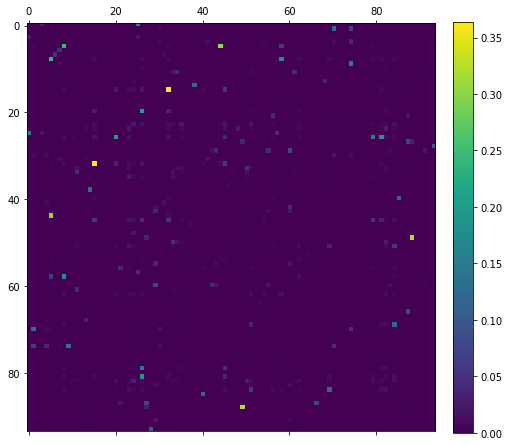

In [28]:
im = plt.matshow(ious)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.show()

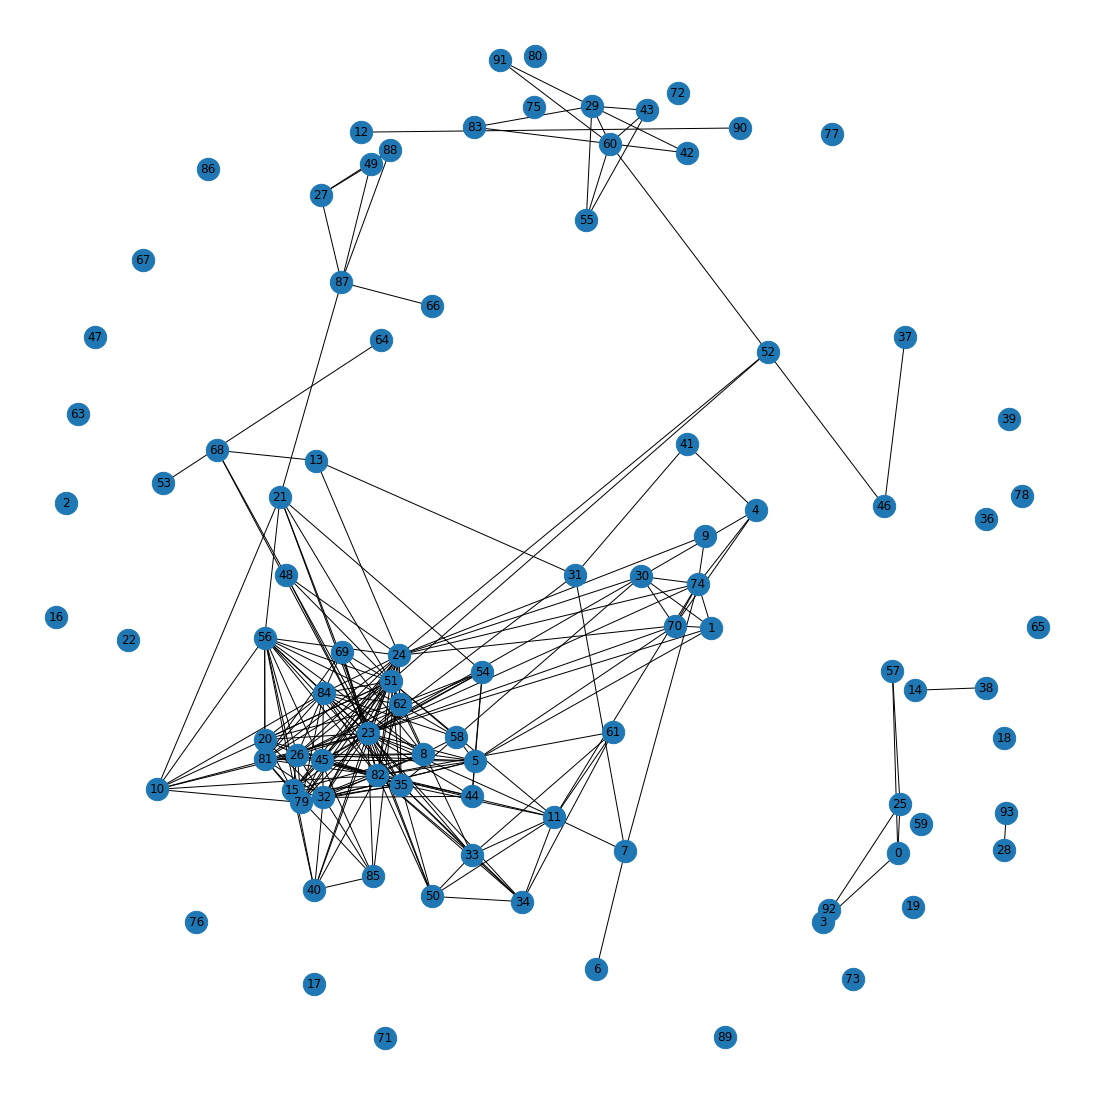

In [29]:
G = nx.Graph(ious)  # you can also threshold ious

plt.figure(figsize=(15, 15))
nx.draw(G, node_size=500, with_labels=True)

In [30]:
# G에 연결되어 있는 요소들의 리스트
components = list([list(k) for k in nx.connected_components(G)])

for i, c in enumerate(components):
    print(f"Component #{i} of length {len(c)}")

Component #0 of length 4
Component #1 of length 49
Component #2 of length 1
Component #3 of length 2
Component #4 of length 2
Component #5 of length 1
Component #6 of length 1
Component #7 of length 1
Component #8 of length 1
Component #9 of length 1
Component #10 of length 2
Component #11 of length 9
Component #12 of length 1
Component #13 of length 1
Component #14 of length 1
Component #15 of length 2
Component #16 of length 1
Component #17 of length 1
Component #18 of length 1
Component #19 of length 1
Component #20 of length 1
Component #21 of length 1
Component #22 of length 1
Component #23 of length 1
Component #24 of length 1
Component #25 of length 1
Component #26 of length 1
Component #27 of length 1
Component #28 of length 1
Component #29 of length 1
Component #30 of length 1


- 첫번째 요소를 첫번째 분할으로 사용 그리고 다른 요소들은 다른 분할으로 사용함
- 요소 1을 node 6과 37로 분할 가능

In [31]:
components[1]

[1,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 13,
 15,
 20,
 21,
 23,
 24,
 26,
 27,
 30,
 31,
 32,
 33,
 34,
 35,
 40,
 41,
 44,
 45,
 48,
 49,
 50,
 51,
 52,
 54,
 56,
 58,
 61,
 62,
 66,
 68,
 69,
 70,
 74,
 79,
 81,
 82,
 84,
 85,
 87,
 88]

In [32]:
channel_val

,channel,id,topic_id,content_ids
0,00a2b4,"[t_02bcfa7b72ec, t_03ea6cb9a100, t_04df4fee08b...","[t_02bcfa7b72ec, t_03ea6cb9a100, t_04df4fee08b...",[c_17c294443a72 c_a1a8ec93ef87 c_dd739e116435 ...
1,018d08,"[t_02dc6d761be0, t_08e133229173, t_0a854d263d4...","[t_02dc6d761be0, t_08e133229173, t_0a854d263d4...","[c_d08720ccc03c, c_09ff49c0fc41 c_5f84b6a898cb..."
2,01dbc1,"[t_00d34df87981, t_04e9089b262b, t_0514fdcbbb7...","[t_00d34df87981, t_04e9089b262b, t_0514fdcbbb7...",[c_58046dd1c0fb c_67bc1202213e c_9546778f4db5 ...
3,02be07,"[t_010709c0bd20, t_09ddd664d97a, t_0cb2fce563c...","[t_010709c0bd20, t_09ddd664d97a, t_0cb2fce563c...","[c_1fb978405868, c_31ac67a4a32c, c_ef1ef3db32d..."
4,03de11,"[t_022173184544, t_05cc9e5e5ace, t_213c274fb8e...","[t_022173184544, t_05cc9e5e5ace, t_213c274fb8e...",[c_1799a40ef38a c_31630aba3e05 c_463dd609a07c ...
...,...,...,...,...
89,f08256,"[t_0ea9bbb76565, t_1406f1a6b5c1, t_2bc5e5c4074...","[t_0ea9bbb76565, t_1406f1a6b5c1, t_2bc5e5c4074...","[c_12afd8ac44f3 c_f091ff657564, c_04355e021c89..."
90,f65044,"[t_05af761272de, t_0716dfd92e2f, t_0926a1d3175...","[t_05af761272de, t_0716dfd92e2f, t_0926a1d3175...",[c_1b6e55cd1ba5 c_74280466106f c_afe51e041bf0 ...
91,f9db19,"[t_0892bf58bd43, t_0b068faa6ecc, t_13cf6498ec7...","[t_0892bf58bd43, t_0b068faa6ecc, t_13cf6498ec7...","[c_332c37eac81c c_8f9fc13f395e c_b686a7ad414d,..."
92,fc1d48,"[t_07971941376e, t_0845c025e1a7, t_0c658abe07c...","[t_07971941376e, t_0845c025e1a7, t_0c658abe07c...","[c_004a1d069666, c_2785814b6cef c_bc7948bbc891..."


In [33]:
channel_val['fold'] = 0
# componet[1]이의 넘파이를 1로 할당 
channel_val.loc[np.array(components[1]), 'fold'] = 1

In [34]:
channel_val[["channel", "fold"]].to_csv('fold.csv')
channel_val[["channel", "fold"]].head()

,channel,fold
0,00a2b4,0
1,018d08,1
2,01dbc1,0
3,02be07,0
4,03de11,1


Done !